#Kvasir


In [ ]:
!nvidia-smi

Wed Jul  2 04:26:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              7W /   60W |     243MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# instala kaggle api y librerias extra
!pip install -q kaggle scikit-learn matplotlib


In [ ]:
# mueve credenciales a la carpeta kaggle y cambia permisos
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:

!kaggle datasets download -d plhalvorsen/kvasir-v2-a-gastrointestinal-tract-dataset -p data
!unzip -q data/kvasir-v2-a-gastrointestinal-tract-dataset.zip -d data

# !unzip -q data/kvasir-dataset-v2.zip -d data

Dataset URL: https://www.kaggle.com/datasets/plhalvorsen/kvasir-v2-a-gastrointestinal-tract-dataset
License(s): CC-BY-SA-4.0
100% 2.32G/2.32G [00:19<00:00, 250MB/s]
100% 2.32G/2.32G [00:19<00:00, 129MB/s]


In [ ]:
!ls data

dyed-lifted-polyps				normal-pylorus
dyed-resection-margins				normal-z-line
esophagitis					polyps
kvasir-v2-a-gastrointestinal-tract-dataset.zip	ulcerative-colitis
normal-cecum


In [ ]:
# ---------------- segunda celda: todo el modelo ----------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, os
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import confusion_matrix, classification_report

# hiperparámetros
img_size   = 300
batch_sz   = 64
seed       = 123
epochs_h   = 12   # epochs cabeza
epochs_ft  = 24  # epochs fine‑tuning
data_dir   = '/content/data'

# gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus: tf.config.experimental.set_memory_growth(gpus[0], True)

# -------- funciones ----------
def crop_resize(img):
    return tf.image.resize(tf.image.central_crop(img, 0.9), (img_size, img_size))

data_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

def preprocess(x, y, train):
    x = tf.cast(x, tf.float32)
    x = crop_resize(x)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    if train: x = data_aug(x, training=True)
    return x, y

AUTOTUNE = tf.data.AUTOTUNE
def prep(ds, train):
    ds = ds.map(lambda x,y: preprocess(x,y,train), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (x, tf.one_hot(y, num_classes)), num_parallel_calls=AUTOTUNE)
    return ds.batch(batch_sz).prefetch(AUTOTUNE)

# -------- carga de datos ----------
all_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, image_size=(img_size,img_size), seed=seed,
    shuffle=True, labels='inferred', label_mode='int', batch_size=None)

num_classes = len(all_ds.class_names)
train_count = int(0.8 * tf.data.experimental.cardinality(all_ds).numpy())
val_count   = int(0.1 * tf.data.experimental.cardinality(all_ds).numpy())

train_raw = all_ds.take(train_count)
val_raw   = all_ds.skip(train_count).take(val_count)
test_raw  = all_ds.skip(train_count + val_count)

train_ds = prep(train_raw, True)
val_ds   = prep(val_raw,  False)
test_ds  = prep(test_raw, False)

# -------- modelo ----------
inputs = layers.Input((img_size,img_size,3))
base   = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_tensor=inputs)
base.trainable = False
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.AdamW(5e-4, weight_decay=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

print('--- fase 1: cabeza ---')
model.fit(train_ds, validation_data=val_ds, epochs=epochs_h, verbose=1)

# -------- fine‑tuning (descongela último 30 % de capas) ----------
for layer in base.layers[int(len(base.layers)*0.7):]:
    layer.trainable = True

lr_schedule = optimizers.schedules.CosineDecay(2e-5, epochs_ft * len(train_ds))
model.compile(optimizer=optimizers.AdamW(lr_schedule, weight_decay=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

print('--- fase 2: fine‑tuning ---')
cb = [callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')]
model.fit(train_ds, validation_data=val_ds, epochs=epochs_ft, callbacks=cb, verbose=1)

# -------- evaluación final ----------
pred = np.argmax(model.predict(test_ds, verbose=0), 1)
true = np.concatenate([np.argmax(y,1) for _,y in test_ds])
print(classification_report(true, pred, target_names=all_ds.class_names))

cm = confusion_matrix(true, pred)
plt.imshow(cm, cmap='Blues'); plt.title('matriz de confusion'); plt.colorbar(); plt.show()

Found 8000 files belonging to 8 classes.
--- fase 1: cabeza ---
Epoch 1/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.3748 - loss: 1.7348 - val_accuracy: 0.7475 - val_loss: 1.0939
Epoch 2/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.7329 - loss: 1.0694 - val_accuracy: 0.7950 - val_loss: 0.9613
Epoch 3/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.7834 - loss: 0.9619 - val_accuracy: 0.8375 - val_loss: 0.8955
Epoch 4/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.8067 - loss: 0.9076 - val_accuracy: 0.8413 - val_loss: 0.8689
Epoch 5/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8146 - loss: 0.9057 - val_accuracy: 0.8388 - val_loss: 0.8711
Epoch 6/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.8332 - loss: 0.8748 - val_accuracy: 0.8388 - val_loss: 0.8616
Epoch 7/12
100/100 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.8357 - loss: 0.8642 - val_accuracy: 0.8475 - val_loss: 0.8361
Epoch 8/12
100/100 ━━━━━━━━━━━━━━

KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 112 variables whereas the saved optimizer has 217 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 108 variables whereas the saved optimizer has 213 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.12      0.10      0.11       106
dyed-resection-margins       0.08      0.09      0.08        89
           esophagitis       0.06      0.04      0.05       108
          normal-cecum       0.11      0.12      0.12       120
        normal-pylorus       0.12      0.12      0.12       110
         normal-z-line       0.13      0.20      0.16        87
                polyps       0.12      0.13      0.12        95
    ulcerative-colitis       0.14      0.14      0.14        85

              accuracy                           0.11       800
             macro avg       0.11      0.12      0.11       800
          weighted avg       0.11      0.11      0.11       800



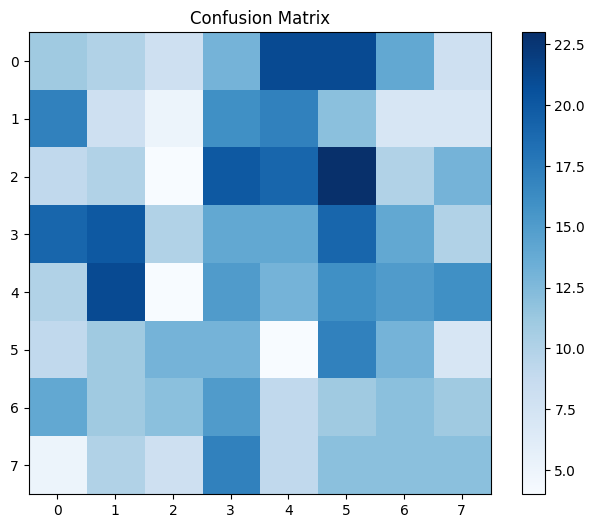

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# guardar el modelo en formato keras
model.save('efficientnetb3_kvasir_model.keras')

# cargar el modelo guardado (formato keras para evitar errores con capas especiales)
model = load_model('efficientnetb3_kvasir_model.keras')

# predecir en el conjunto de prueba
pred = np.argmax(model.predict(test_ds, verbose=1), axis=1)

# obtener etiquetas reales del conjunto de prueba
true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds])

# imprimir reporte de clasificación
print(classification_report(true, pred, target_names=all_ds.class_names))

# matriz de confusion
cm = confusion_matrix(true, pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()